# Saliency map analysis

In [1]:
import sys
import h5py

import numpy as np
import pandas as pd
from glob import glob
from copy import copy

from tensorflow import keras

from eofs.standard import Eof
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter, map_coordinates

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')

import data_utils as du
import graph_utils as gu
from namelist import *

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

fig_dir = '/glade/u/home/ksha/figures/'
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# BC and Ca-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

shape_dir = fig_dir+'wshed_hires/MajorHydroWatershedsProject.shp'
#
stn_grids = np.load('/glade/scratch/ksha/BACKUP/station_latlon_64.npy', allow_pickle=True)

In [5]:
JET = []
JET.append(gu.xcolor('indian red'))
JET.append(gu.xcolor('gold'))
JET.append(gu.xcolor('dark sea green'))
JET.append(gu.xcolor('deep sky blue'))
JET.append(gu.xcolor('royal blue'))

JET = JET[::-1]

In [6]:
# ens = 3
# freq = 'LOW_'
save_dir = '/glade/work/ksha/data/Keras/QC_publish/'
eval_dir = '/glade/work/ksha/data/evaluation/'
fig_dir = '/glade/u/home/ksha/figures/'
data_dir0 = HOLD_dir+freq+'CAPA_TRAIN_pack.hdf'
data_dir1 = HOLD_dir+freq+'CAPA_VALID_pack.hdf'
data_dir2 = HOLD_dir+freq+'CAPA_TEST_pack.hdf'

In [7]:
with pd.HDFStore(BACKUP_dir+'BCH_metadata_zoned.hdf', 'r') as hdf_temp:
    metadata = hdf_temp['metadata']

stn_code = metadata['code'].values.tolist()
stn_lat = metadata['lat'].values
stn_lon = metadata['lon'].values
loc_id = metadata['zone'].values
stn_elev = metadata['elev [m]'].values

with pd.HDFStore(BACKUP_dir+'BCH_combine.hdf', 'r') as hdf_temp:
    keys = hdf_temp.keys()
    
keys = du.del_slash(keys)
inds = du.str_search(stn_code, keys)
L = len(stn_code); flag_pick = du.ind_to_flag(inds, L)

stn_pick = np.array(stn_code)[flag_pick]
lon_pick = np.array(stn_lon)[flag_pick]
lat_pick = np.array(stn_lat)[flag_pick]

loc_pick = loc_id[flag_pick]

# print(stn_pick[loc_pick==0])
# print(stn_pick[loc_pick==1])
# print(stn_pick[loc_pick==2])
# print(stn_pick[loc_pick==3])

duplicate items (will pick the last one)
1 --> GOL
56 --> GOL
duplicate items (will pick the last one)
0 --> ILL
64 --> ILL
duplicate items (will pick the last one)
3 --> KEY
66 --> KEY


In [10]:
eval_dir = '/glade/work/ksha/data/evaluation/saliency_maps/'
data_temp = np.load('/glade/work/ksha/data/evaluation/EVAL_QC_members.npy', allow_pickle=True)
cate_p_all = data_temp[()]['cate_train']

In [12]:
ens = 5 # 5 classifiers
dict_stn = {}; 
for n in range(ens):
    code_list = []; sample_list = []
    print('Classifier {}'.format(n))
    # import saliency map calculations
    hdf_io = h5py.File(eval_dir+'HIGH_QC_CNN{}_saliency_top100_part0.hdf'.format(n), 'r')
    ind_e_part0 = hdf_io['ind_example'][...]
    ind_n_part0 = hdf_io['ind_neuron'][...]
    grad_part0 = hdf_io['gradient'][...]
    hdf_io.close()
    hdf_io = h5py.File(eval_dir+'HIGH_QC_CNN{}_saliency_top100_part1.hdf'.format(n), 'r')
    ind_e_part1 = hdf_io['ind_example'][...]
    ind_n_part1 = hdf_io['ind_neuron'][...]
    grad_part1 = hdf_io['gradient'][...]
    hdf_io.close()
    ind_e = np.hstack([ind_e_part0, ind_e_part1])
    ind_n = np.hstack([ind_n_part0, ind_n_part1])
    grad = np.vstack([grad_part0, grad_part1])
    #
    key = freq+'QC_CNN'+str(n)
    model = keras.models.load_model(save_dir+key+'.hdf')
    W = np.squeeze(model.layers[-1].get_weights()[0])[ind_n]
    V = np.sqrt(np.sum(W**2))
    W = W/V
    #
    grad = grad*W[:, None, None, None, None]
    #
    cate_p = cate_p_all[:, n] >= 0.5
    #
    key = freq+'QC_CNN'+str(n)
    model = keras.models.load_model(save_dir+key+'.hdf')
    W = np.squeeze(model.layers[-1].get_weights()[0])[ind_n]
    V = np.sqrt(np.sum(W**2))
    W = W/V
    #
    ind_temp = ind_e.flatten()
    grad_flat = grad.reshape(432*100, 64, 64, 2)
    cate_temp = cate_train[ind_temp]
    pred_temp = cate_p[ind_temp]
    grid_temp = grid_train[ind_temp, ..., 2*n:2*(n+1)]

    stn_temp = np.array(code_train)[ind_temp].tolist()
    stn_unique, stn_counts, = du.str_count(stn_temp, print_out=False)
    L = len(stn_unique)
    for i, code in enumerate(stn_unique):
        flag = np.logical_and(np.logical_and(np.array(stn_temp)==code, pred_temp==cate_temp), pred_temp==False)
        if np.sum(flag) >= 100:
            code_list.append(code)
            sample_list.append(np.sum(flag))
            dict_stn[code+'_grad_ens'+str(n)] = grad_flat[flag, ...]
            dict_stn[code+'_grid_ens'+str(n)] = grid_temp[flag, ..., 0]
        dict_stn['stn_list_ens'+str(n)] = (code_list, sample_list)

Classifier 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Classifier 1
Classifier 2
Classifier 3
Classifier 4


In [3]:
# identifying typical stations
# for n in range(ens):
#     L = len(dict_stn['stn_list_ens'+str(n)][0])
#     for i in range(L):
#         if dict_stn['stn_list_ens'+str(n)][1][i]>10 and loc_pick[stn_pick==dict_stn['stn_list_ens'+str(n)][0][i]] == 2:
#             print('{} - {}'.format(dict_stn['stn_list_ens'+str(n)][0][i], dict_stn['stn_list_ens'+str(n)][1][i]))
#     print('=======')

In [16]:
N = 4
# selected station codes
stns_all = [['GLD', 'GRT', 'HFG'],
            ['GLD', 'DBC', 'HFG'],
            ['GLD', 'GRT', 'HFG'],
            ['GLD', 'GRT', 'HFG'],
            ['GLD', 'GRT', 'HFG']]

L = len(stns_all[0])
dict_grad = {}
dict_grid = {}
dict_expvar = {}
dict_code = {}
for n in range(ens):
    stns = stns_all[n]
    PCA_grad = np.empty((L, N,)+(64, 64))
    PCA_grid = np.empty((L, N,)+(64, 64))
    expvar = np.empty([L, N])
    for s, stn in enumerate(stns):
        print(stn) 
        grad_ens = dict_stn[stn+'_grad_ens'+str(n)][..., 0]
        grid_ens = dict_stn[stn+'_grid_ens'+str(n)]
        solver = Eof(grad_ens)
        PCA_grad[s, ...] = solver.eofs(neofs=4)
        PCs = solver.pcs(npcs=4, pcscaling=1)
        expvar[s, :] = solver.varianceFraction()[:N]
        for i in range(N):
            PCA_grad[s, i, ...] = du.norm_std(gaussian_filter(PCA_grad[s, i, ...], 2.5))
            stn_val = PCA_grad[s, i, 32, 32]
            if stn_val > 0:
                PCA_grad[s, i, ...] = -1*PCA_grad[s, i, ...]
                PCs[:, i] = -1*PCs[:, i]
            PCA_grid[s, i, ...] = np.mean(grid_ens[PCs[:, i]>1.5, ...], axis=0)
    dict_grad['ENS'+str(n)] = PCA_grad
    dict_grid['ENS'+str(n)] = PCA_grid
    dict_expvar['ENS'+str(n)] = expvar
    dict_code['ENS'+str(n)] = stns

GLD
GRT
HFG
GLD
DBC
HFG
GLD
GRT
HFG


/glade/work/ksha/py_env_20190723/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/work/ksha/py_env_20190723/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


GLD
GRT
HFG
GLD
GRT
HFG


In [17]:
# save results
# save_name = '/glade/work/ksha/data/evaluation/saliency_maps/PCA_out.npy'
# save_d = {'grad':dict_grad, 'grid':dict_grid, 'expvar':dict_expvar, 'code':dict_code}
# np.save(save_name, save_d)

# Visualizing saliency maps

In [11]:
# importing results
save_name = '/glade/work/ksha/data/evaluation/saliency_maps/PCA_out.npy'
temp_data = np.load(save_name, allow_pickle=True)
dict_grad = temp_data[()]['grad']
dict_grid = temp_data[()]['grid']
dict_code = temp_data[()]['code']
dict_expvar = temp_data[()]['expvar']

In [13]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [14]:
#np.arange(0-gap_l*n_l-0.5*gap_l, 0+gap_l*n_l+0.5*gap_l, gap_l)

In [15]:
my_color = copy(truncate_colormap(plt.cm.terrain, 0.1, 1))
my_color.set_under('white', 0.05)

In [16]:
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

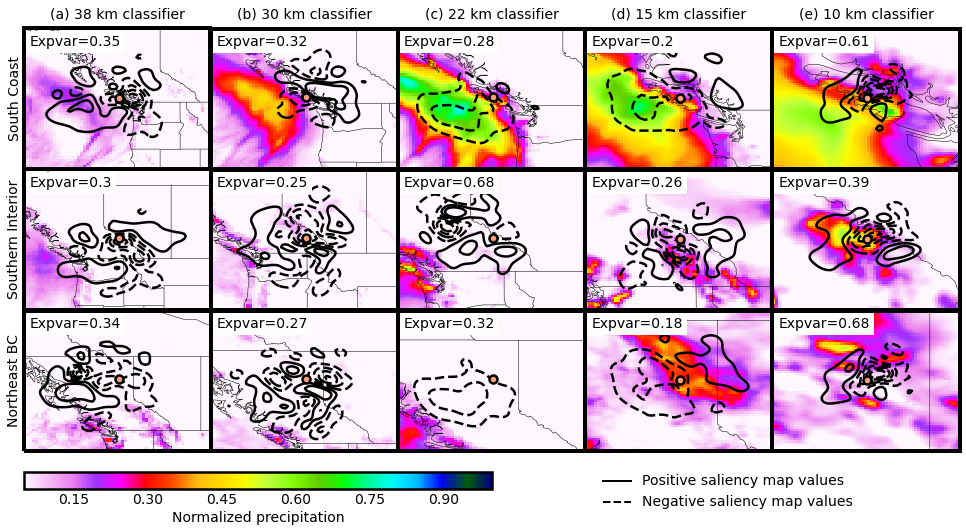

In [23]:
labels = ['10 km', '15 km', '22 km', '30 km', '38 km'][::-1]

gap_l = 1.8; n_l = 4; p_l = 2 
lev = np.arange(0-gap_l*n_l-0.5*gap_l, 0+gap_l*p_l+0.5*gap_l, gap_l)
latlon_rate = [0.74, 0.75, 0.75, 0.75, 0.75];

fig, AX = plt.subplots(3, ens, figsize=(13, 5.875), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)
AX = AX.T
for n, AX_sub in enumerate(AX):
    stns = dict_code['ENS'+str(n)]
    PCA_grad = dict_grad['ENS'+str(n)]
    PCA_grid = dict_grid['ENS'+str(n)]
    expvar = dict_expvar['ENS'+str(n)]
    
    for s, ax in enumerate(AX_sub):
        stn = stns[s]
        #
        xgrid = stn_grids[()][stn][2*n, ...]
        ygrid = stn_grids[()][stn][2*n+1, ...]
        #
        dx = xgrid.max()-xgrid.min()
        edge = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.min()+latlon_rate[n]*dx]
        #
        ax.set_extent(edge, ccrs.Geodetic())
        ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
        ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=0.5)
        ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=0.5)
        ax.outline_patch.set_linewidth(4)
        #
        handle = ax.text(0.0325, 0.875, 'Expvar={}'.format(np.around(expvar[s, 0]+0.1, 2)), 
                         fontsize=14, transform=ax.transAxes)
        handle.set_bbox(dict(facecolor='w', alpha=1, edgecolor='none'))
        
        CS = ax.pcolormesh(xgrid, ygrid, PCA_grid[s, 0, ...], vmin=0.05, vmax=1, cmap=plt.cm.gist_ncar_r)
        ax.contour(xgrid, ygrid, PCA_grad[s, 0, ...], lev, colors=('k',), linewidths=(2.5,))
        ax.plot(xgrid[32, 32], ygrid[32, 32], 'ro', ms=8, mfc=gu.xcolor('light salmon'), mec='k', mew=2.5, zorder=5)

handle1 = mlines.Line2D([], [], color='k', linewidth=2, linestyle='-', label='Positive saliency map values')
handle2 = mlines.Line2D([], [], color='k', linewidth=2, linestyle='--', label='Negative saliency map values')

ax_lg = fig.add_axes([0.6, -0.125, 0.3, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=[handle1, handle2], bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)
LG.get_frame().set_alpha(1.0)


ax_base = fig.add_axes([0.001, -0.15, 0.5, 0.1]) # 0.52, 0.2535, 0.4615, 0.07
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, width='100%', height='40%', borderpad=0, loc=9)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax)
CBar.set_label('Normalized precipitation', fontsize=14)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
tick_locator = ticker.MaxNLocator(nbins=7)
CBar.locator = tick_locator
CBar.update_ticks()
CBar.outline.set_linewidth(2.5)

AX[0][0].text(-0.05, 0.5, 'South Coast', rotation=90, 
              ha='center', va='center', fontsize=14, transform=AX[0][0].transAxes);
AX[0][1].text(-0.05, 0.5, 'Southern Interior', rotation=90, 
              ha='center', va='center', fontsize=14, transform=AX[0][1].transAxes);
AX[0][2].text(-0.05, 0.5, 'Northeast BC', rotation=90, 
              ha='center', va='center', fontsize=14, transform=AX[0][2].transAxes);

AX[0][0].text(0.5, 1.1, '(a) 38 km classifier', ha='center', va='center', fontsize=14, transform=AX[0][0].transAxes);
AX[1][0].text(0.5, 1.1, '(b) 30 km classifier', ha='center', va='center', fontsize=14, transform=AX[1][0].transAxes);
AX[2][0].text(0.5, 1.1, '(c) 22 km classifier', ha='center', va='center', fontsize=14, transform=AX[2][0].transAxes);
AX[3][0].text(0.5, 1.1, '(d) 15 km classifier', ha='center', va='center', fontsize=14, transform=AX[3][0].transAxes);
AX[4][0].text(0.5, 1.1, '(e) 10 km classifier', ha='center', va='center', fontsize=14, transform=AX[4][0].transAxes);

fig.savefig(fig_dir+'QC_saliency_maps.png', dpi=250, orientation='portrait', \
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)